In [ ]:
# 데이터 다운로드 https://drive.google.com/file/d/1PuyTxcrPRcIEiMB71-asfDv8nXJToxxr/view?usp=share_link
!gdown 'https://drive.google.com/uc?export=download&id=1PuyTxcrPRcIEiMB71-asfDv8nXJToxxr'

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&id=1PuyTxcrPRcIEiMB71-asfDv8nXJToxxr 



In [ ]:
import os

os.makedirs('/content/data', exist_ok=True)

In [ ]:
!tar -xvf '/content/cat_dog.tar' -C '/content/data'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
cat_dog/training_set/cats/cat.3703.jpg
cat_dog/training_set/cats/cat.3704.jpg
cat_dog/training_set/cats/cat.3705.jpg
cat_dog/training_set/cats/cat.3706.jpg
cat_dog/training_set/cats/cat.3707.jpg
cat_dog/training_set/cats/cat.3708.jpg
cat_dog/training_set/cats/cat.3709.jpg
cat_dog/training_set/cats/cat.371.jpg
cat_dog/training_set/cats/cat.3710.jpg
cat_dog/training_set/cats/cat.3711.jpg
cat_dog/training_set/cats/cat.3712.jpg
cat_dog/training_set/cats/cat.3713.jpg
cat_dog/training_set/cats/cat.3714.jpg
cat_dog/training_set/cats/cat.3715.jpg
cat_dog/training_set/cats/cat.3716.jpg
cat_dog/training_set/cats/cat.3717.jpg
cat_dog/training_set/cats/cat.3718.jpg
cat_dog/training_set/cats/cat.3719.jpg
cat_dog/training_set/cats/cat.372.jpg
cat_dog/training_set/cats/cat.3720.jpg
cat_dog/training_set/cats/cat.3721.jpg
cat_dog/training_set/cats/cat.3722.jpg
cat_dog/training_set/cats/cat.3723.jpg
cat_dog/training_set/cats/cat.3724.jpg
cat_dog/training_set/cats/cat.

In [ ]:
train_root = '/content/data/cat_dog/training_set'

train_cats_path = sorted([os.path.join(train_root, 'cats', file) 
                        for file in os.listdir(os.path.join(train_root, 'cats'))])
train_dogs_path = sorted([os.path.join(train_root, 'dogs', file) 
                        for file in os.listdir(os.path.join(train_root, 'dogs'))])

In [ ]:
test_root = '/content/data/cat_dog/test_set'

test_cats_path = sorted([os.path.join(test_root, 'cats', file) 
                        for file in os.listdir(os.path.join(test_root, 'cats'))])
test_dogs_path = sorted([os.path.join(test_root, 'dogs', file) 
                        for file in os.listdir(os.path.join(test_root, 'dogs'))])

In [ ]:
print('Trainging => 고양이 이미지 수: ', len(train_cats_path), ', 강이지 이미지 수: ', len(train_dogs_path))
print('Test => 고양이 이미지 수: ', len(test_cats_path), ', 강이지 이미지 수: ', len(test_dogs_path))

Trainging => 고양이 이미지 수:  4000 , 강이지 이미지 수:  4005
Test => 고양이 이미지 수:  1011 , 강이지 이미지 수:  1012


In [ ]:
train_total_path = train_cats_path + train_dogs_path
test_total_path = test_cats_path + test_dogs_path

In [ ]:
test_total_path[100].split('/')[-2]

'cats'

In [ ]:
import os
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time # 시간 측정을 위해

### Custom Data Loader 만들기

In [ ]:
class Train_Cats_Dogs_dataset(Dataset):
  '''
  Cat & Dog 데이터셋
  Cat -> 0 (정답)
  Dog -> 1 (정답)

  '''
  def __init__(self, input_path, transform=None):
    super(Train_Cats_Dogs_dataset, self).__init__()

    self.input_path = input_path
    self.transform = transform

  def __len__(self):
    return len(self.input_path)

  def __getitem__(self, idx):
    inp_path = self.input_path[idx]
    
    input_img = Image.open(inp_path).convert('RGB')

    if inp_path.split('/')[-2] == 'cats':
      target = 0
    elif inp_path.split('/')[-2] == 'dogs':
      target = 1

    if self.transform is not None:
      input_img = self.transform(input_img)

    return input_img, target

class Val_Test_Cats_Dogs_dataset(Dataset):
  '''
  Cat & Dog 데이터셋
  Cat -> 0 (정답)
  Dog -> 1 (정답)

  '''
  def __init__(self, input_path, transform=None):
    super(Val_Test_Cats_Dogs_dataset, self).__init__()

    self.input_path = input_path
    self.transform = transform

  def __len__(self):
    return len(self.input_path)

  def __getitem__(self, idx):
    inp_path = self.input_path[idx]
    
    input_img = Image.open(inp_path).convert('RGB')

    if inp_path.split('/')[-2] == 'cats':
      target = 0
    elif inp_path.split('/')[-2] == 'dogs':
      target = 1

    if self.transform is not None:
      input_img = self.transform(input_img)

    return input_img, target

### Model

In [ ]:
class cnn_classfier_v2(nn.Module):
  def __init__(self, in_ch, hidden_dim, out_ch):
    super(cnn_classfier_v2, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_ch, hidden_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 64 64

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 32 32

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 16 16

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(hidden_dim*4, hidden_dim*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*8),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 8 8

    self.dropout = nn.Dropout(p=0.3)
    self.fc1 = nn.Linear(in_features=hidden_dim*8*8*8, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=out_ch)
    #self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    c1 = self.conv_block1(x)

    c2 = self.conv_block2(c1)

    c3 = self.conv_block3(c2)

    c4 = self.conv_block4(c3)

    out = c4.view(x.size(0), -1)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.dropout(out)
    out = self.fc3(out)

    return out

In [ ]:
class Trainer(nn.Module):
  def __init__(self, lr, epochs, save_root, optimizer, device):
    super(Trainer, self).__init__()

    self.epochs = epochs
    self.device = device
    self.lr = lr

    self.save_root = save_root

    self.model = cnn_classfier_v2(in_ch=3, hidden_dim=32, out_ch=2)
    
    if optimizer == 'sgd':
      self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
    elif optimizer == 'adam':
      self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    #self.loss = nn.BCELoss()
    self.loss = nn.CrossEntropyLoss()

  def train(self, train_loader, valid_loader):
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    
    check_valid_acc = 0
    for epoch in range(1, self.epochs+1):
      epoch_start_time = time.time()
      train_loss, train_acc = self._train_epoch(train_loader) 
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      print(f'epoch : {epoch}, train loss : {train_loss}, train_acc : {train_acc}, valid_loss : {valid_loss}, valid_acc : {acc}')

      if valid_acc > check_valid_acc: # 이전 validation accuracy와 비교해서 더 높은 accuracy일 때 model weights를 저장합니다.
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
        }, os.path.join(self.save_root, 'model.pth'))
        check_valid_acc = valid_acc

      self.visualize_graph(history)

  def _train_epoch(self, train_loader):
    epoch_loss = 0
    epoch_acc = 0
    cnt = 0
    self.model.train()
    print('train start')
    for step, data in enumerate(train_loader):
      cnt += 1

      # data = [img, label] 이런 형식으로 value가 저장되어 있다.
      # GPU 연산을 하기 위해서 .to() 를 이용하여 data를 gpu에 맞는 type으로 변환해 준다.
      input = data[0].to(self.device)
      target = data[1].to(self.device)

      # model에 image input data를 넣어 prediction 값을 얻는다.
      prediction = self.model(input)

      # 예측값과 실제값 사이의 오차를 구한다.
      loss = self.loss(prediction, target)

      # optimizer 및 loss 를 update 해준다.
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # epoch 의 평균 loss와 acc를 구하는 부분이다.
      # .item() 을 통해서 value 만 얻어온다.
      # 이때 tensor 형식인 값을 numpy 연산하기 위해서 'gpu' --> 'cpu' 로 바꾸어 준다.
      # gpu에서 cpu 로 바꾸게 되면 tensor 형식에서 numpy 형식으로 변환된다.
      epoch_loss += loss.to('cpu').item()

      # argmax 는 해당 array 에서 가장 높은 값이 있는 index 를 얻어 오는 함수이다.
      epoch_acc += (prediction.argmax(1) == target).type(torch.float).to('cpu').mean().item()
     
      # 20번째 step 마다 loss와 acc를 확인한다.
      if step % 20 == 0:
        print(f'step : {cnt}/{len(train_loader)}, loss : {epoch_loss / cnt}, acc : {epoch_acc / cnt}')

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)

    return epoch_loss, epoch_acc
      
  def _valid_epoch(self, valid_loader):
    epoch_loss = 0
    epoch_acc = 0
    cnt = 0
    self.model.eval()
    print('validation start')

    # no_grad --> 학습에 영향이 가지 않도록 하는 함수
    # validation 은 단순히 학습된 model의 성능을 평가하기 위함으로 model의 학습에 영향을 끼쳐서는 안된다.
    with torch.no_grad():
      for step, data in enumerate(valid_loader):
        cnt += 1
        input = data[0].to(self.device)
        target = data[1].to(self.device)

        prediction = self.model(input)
        loss = self.loss(prediction, target)

        epoch_loss += loss.to('cpu').item()
        epoch_acc += (prediction.argmax(1) == target).type(torch.float).to('cpu').mean().item()
        
        if step % 100 == 0:
          print(f'step : {cnt}/{len(valid_loader)}, loss : {epoch_loss / cnt}, acc : {epoch_acc / cnt}')

      epoch_loss /= len(valid_loader)
      epoch_acc /= len(valid_loader)

    return epoch_loss, epoch_acc

  def test(self, test_loader, model_weights_path):
    epoch_loss = 0
    epoch_acc = 0

    checkpoint = torch.load(model_weights_path)

    test_model = cnn_classfier_v2(in_ch=3, hidden_dim=32, out_ch=2).to(self.device)
    test_model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    test_model.eval()
    print('test start')
    with torch.no_grad():
      for step, data in enumerate(test_loader):
        input = data[0].to(self.device)
        target = data[1].to(self.device)

        prediction = test_model(input)
        loss = self.loss(prediction, target)
        #loss = self.loss(prediction, target.unsqueeze(1).float())

        epoch_loss += loss.to('cpu').item()
        #epoch_acc += (torch.where(prediction > 0.5, 1, 0) == target.unsqueeze(1).float()).type(torch.float).to('cpu').mean().item()
        epoch_acc += (prediction.argmax(0) == target).type(torch.float).to('cpu').mean().item()

      epoch_loss /= len(test_loader)
      epoch_acc /= len(test_loader)

    print(f'epoch : {epoch}, test loss : {epoch_loss}, epoch_acc : {epoch_acc}')
    # print('epoch: {}\ttest loss: {:.6f}\ttest accuracy: {:.6f}'.format(epoch, epoch_loss, epoch_acc))

  def visualize_graph(self, history):
    plt.figure(figsize=[20, 5])
    plt.subplot(1, 2, 1)
    plt.title('Loss Trend')
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['valid_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss value')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy Trend')
    plt.plot(history['train_acc'], label='train acc')
    plt.plot(history['valid_acc'], label='valid acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

### 데이터 불러오기

In [ ]:
Train_image_transforms = transforms.Compose(
    [
        transforms.Resize(size=(128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)
Val_Test_image_transforms = transforms.Compose(
    [
        transforms.Resize(size=(128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

In [ ]:
test = Val_Test_Cats_Dogs_dataset(test_total_path, transform=Val_Test_image_transforms)
sample_x, sample_y = test[0]
print(type(sample_x), sample_x.shape)
print(type(sample_y), sample_y)

<class 'torch.Tensor'> torch.Size([3, 128, 128])
<class 'int'> 0


In [ ]:
def split_train_val_test(train_input_path, test_input_path, train_transform=None, eval_transform=None, valid_ratio=0.1):
  random.shuffle(train_input_path)
  random.shuffle(test_input_path)
  num_val = int(len(train_input_path) * valid_ratio) # validation dataset 개수

  valid_path = train_input_path[:num_val] # validataion path
  train_path = train_input_path[num_val:] # test path

  train = Train_Cats_Dogs_dataset(train_path, transform=train_transform)
  valid = Val_Test_Cats_Dogs_dataset(valid_path, transform=eval_transform)
  test = Val_Test_Cats_Dogs_dataset(test_input_path, transform=eval_transform)
  return train, valid, test

In [ ]:
Cats_Dogs_train, Cats_Dogs_valid, Cats_Dogs_test = split_train_val_test(train_total_path, test_total_path, train_transform=Train_image_transforms, eval_transform=Val_Test_image_transforms, valid_ratio=0.1)

print(len(Cats_Dogs_train), len(Cats_Dogs_valid), len(Cats_Dogs_test))

7205 800 2023


In [ ]:
class cnn_classfier_v2(nn.Module):
  def __init__(self, in_ch, hidden_dim, out_ch):
    super(cnn_classfier_v2, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_ch, hidden_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 64 64

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 32 32

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 16 16

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(hidden_dim*4, hidden_dim*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_dim*8),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 8 8

    self.dropout = nn.Dropout(p=0.3)
    self.fc1 = nn.Linear(in_features=hidden_dim*8*8*8, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=out_ch)
    #self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    c1 = self.conv_block1(x)

    c2 = self.conv_block2(c1)

    c3 = self.conv_block3(c2)

    c4 = self.conv_block4(c3)

    out = c4.view(x.size(0), -1)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.dropout(out)
    out = self.fc3(out)

    return out

In [ ]:
from torch.utils.data import DataLoader
# dataloader 정의
train_loader = DataLoader(dataset=Cats_Dogs_train, batch_size=16, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=Cats_Dogs_valid, batch_size=16, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=Cats_Dogs_test, batch_size=1, shuffle=False, drop_last=True)

train start
step : 1/450, loss : 0.8263775110244751, acc : 0.1875
step : 21/450, loss : 28.264840040888107, acc : 0.44047619047619047
step : 41/450, loss : 16.276489452617923, acc : 0.49085365853658536
step : 61/450, loss : 11.547164037579396, acc : 0.48258196721311475
step : 81/450, loss : 8.971627724023513, acc : 0.48302469135802467
step : 101/450, loss : 7.357957793934511, acc : 0.48948019801980197
step : 121/450, loss : 6.296151562663149, acc : 0.5020661157024794
step : 141/450, loss : 5.523904540860061, acc : 0.5044326241134752
step : 161/450, loss : 4.946034778719363, acc : 0.5050465838509317
step : 181/450, loss : 4.488333386940192, acc : 0.5100138121546961
step : 201/450, loss : 4.123085803060389, acc : 0.5127487562189055
step : 221/450, loss : 3.836316825442724, acc : 0.5135746606334841
step : 241/450, loss : 3.5874393358517485, acc : 0.5171161825726142
step : 261/450, loss : 3.3685984777079687, acc : 0.5184386973180076
step : 281/450, loss : 3.182050999903594, acc : 0.5240213

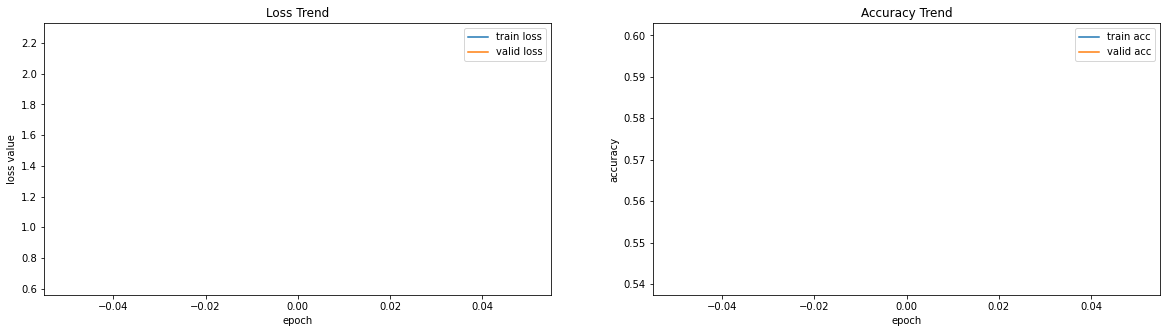

train start
step : 1/450, loss : 0.675936222076416, acc : 0.5625
step : 21/450, loss : 0.740032346475692, acc : 0.5714285714285714
step : 41/450, loss : 0.7033343198822766, acc : 0.6021341463414634
step : 61/450, loss : 0.6987438338701842, acc : 0.5973360655737705
step : 81/450, loss : 0.6841815452516815, acc : 0.6018518518518519
step : 101/450, loss : 0.686545478825522, acc : 0.6008663366336634
step : 121/450, loss : 0.6808415772008501, acc : 0.5996900826446281
step : 141/450, loss : 0.6788945128308966, acc : 0.6050531914893617
step : 161/450, loss : 0.6819000956804856, acc : 0.6013198757763976
step : 181/450, loss : 0.6797092581651487, acc : 0.6042817679558011
step : 201/450, loss : 0.682178422734512, acc : 0.6007462686567164
step : 221/450, loss : 0.6825809734978827, acc : 0.5972850678733032
step : 241/450, loss : 0.6805960876071107, acc : 0.6026970954356846
step : 261/450, loss : 0.6817593153180748, acc : 0.600095785440613
step : 281/450, loss : 0.6836755088003504, acc : 0.59630782

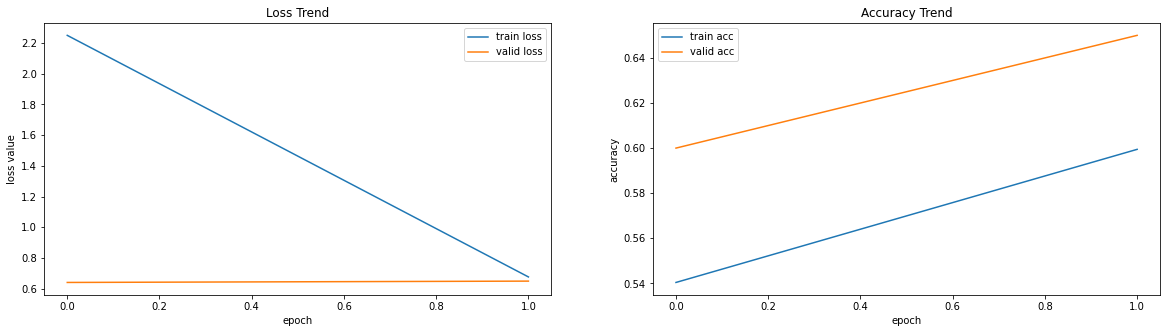

train start
step : 1/450, loss : 0.7980261445045471, acc : 0.5625
step : 21/450, loss : 0.6603293362117949, acc : 0.6339285714285714
step : 41/450, loss : 0.6497289320317711, acc : 0.6341463414634146
step : 61/450, loss : 0.6491152673471169, acc : 0.6424180327868853
step : 81/450, loss : 0.6595622602804208, acc : 0.6296296296296297
step : 101/450, loss : 0.6541897365362337, acc : 0.6386138613861386
step : 121/450, loss : 0.6595980162955513, acc : 0.6348140495867769
step : 141/450, loss : 0.659432609875997, acc : 0.6347517730496454
step : 161/450, loss : 0.6682019533577913, acc : 0.6261645962732919
step : 181/450, loss : 0.6766031549121794, acc : 0.6263812154696132
step : 201/450, loss : 0.6715678858816327, acc : 0.6296641791044776
step : 221/450, loss : 0.6743842413252835, acc : 0.6258484162895928
step : 241/450, loss : 0.6763693778099361, acc : 0.6231846473029046
step : 261/450, loss : 0.6743818309115267, acc : 0.6242816091954023
step : 281/450, loss : 0.671720933447529, acc : 0.62544

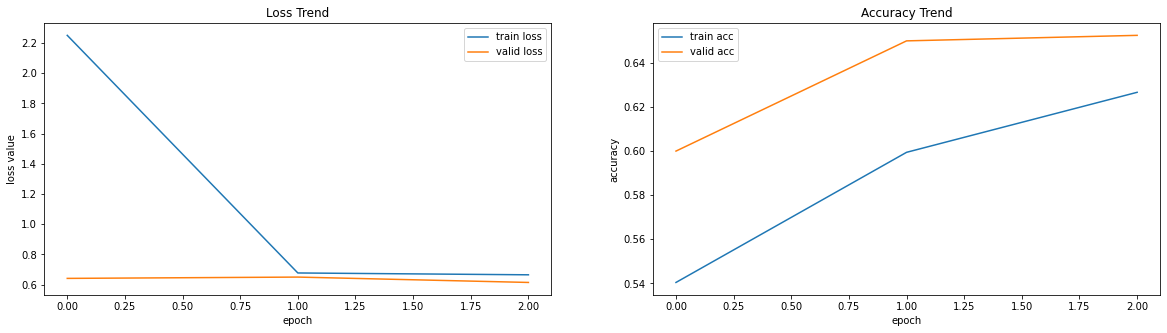

train start
step : 1/450, loss : 0.5707617998123169, acc : 0.5625
step : 21/450, loss : 0.604801207780838, acc : 0.6696428571428571
step : 41/450, loss : 0.6051933714529363, acc : 0.6783536585365854
step : 61/450, loss : 0.6092711672431133, acc : 0.6772540983606558
step : 81/450, loss : 0.6283098220089336, acc : 0.654320987654321
step : 101/450, loss : 0.631470264184593, acc : 0.6571782178217822
step : 121/450, loss : 0.6530899604982581, acc : 0.6430785123966942
step : 141/450, loss : 0.6423799566766049, acc : 0.6511524822695035
step : 161/450, loss : 0.6499356266504489, acc : 0.6471273291925466
step : 181/450, loss : 0.6506098036278677, acc : 0.642610497237569
step : 201/450, loss : 0.6475459503297188, acc : 0.6486318407960199
step : 221/450, loss : 0.6451559991858125, acc : 0.6470588235294118
step : 241/450, loss : 0.6488978272899057, acc : 0.6467842323651453
step : 261/450, loss : 0.6467980441005751, acc : 0.6472701149425287
step : 281/450, loss : 0.6406977426433054, acc : 0.6519128

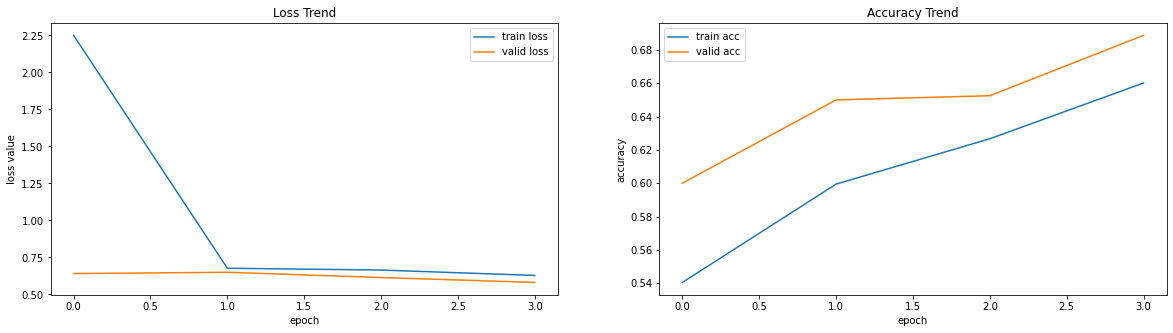

train start
step : 1/450, loss : 0.48890361189842224, acc : 0.875
step : 21/450, loss : 0.5935669612316858, acc : 0.6845238095238095
step : 41/450, loss : 0.6145248500312247, acc : 0.6676829268292683
step : 61/450, loss : 0.6255219798596179, acc : 0.6577868852459017
step : 81/450, loss : 0.6359729049382387, acc : 0.6489197530864198
step : 101/450, loss : 0.625095914791126, acc : 0.6602722772277227
step : 121/450, loss : 0.6196901101218767, acc : 0.6616735537190083
step : 141/450, loss : 0.6011309027671814, acc : 0.6773049645390071
step : 161/450, loss : 0.5980887594430343, acc : 0.6836180124223602
step : 181/450, loss : 0.6004146752436517, acc : 0.6833563535911602
step : 201/450, loss : 0.603035155072141, acc : 0.6809701492537313
step : 221/450, loss : 0.6070577796228331, acc : 0.6773190045248869
step : 241/450, loss : 0.6069769943403506, acc : 0.6784232365145229
step : 261/450, loss : 0.603245642678491, acc : 0.6807950191570882
step : 281/450, loss : 0.6014685121719523, acc : 0.682829

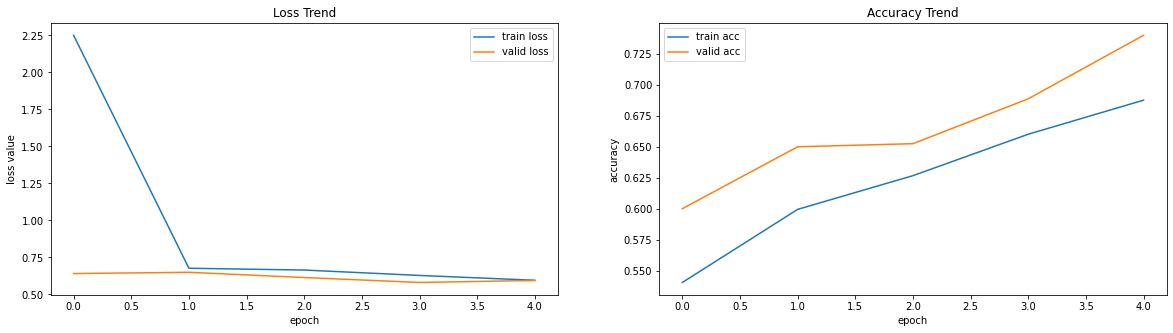

train start
step : 1/450, loss : 0.6731584072113037, acc : 0.5625
step : 21/450, loss : 0.552591887258348, acc : 0.7113095238095238
step : 41/450, loss : 0.5796793314014993, acc : 0.7210365853658537
step : 61/450, loss : 0.5576834747048675, acc : 0.7336065573770492
step : 81/450, loss : 0.5574289438901124, acc : 0.7322530864197531
step : 101/450, loss : 0.5721439447733435, acc : 0.7277227722772277
step : 121/450, loss : 0.5743051752571232, acc : 0.7159090909090909
step : 141/450, loss : 0.5775404703532551, acc : 0.7105496453900709
step : 161/450, loss : 0.5805933477345461, acc : 0.7127329192546584
step : 181/450, loss : 0.5780856780584346, acc : 0.7123618784530387
step : 201/450, loss : 0.5735772183878505, acc : 0.7151741293532339
step : 221/450, loss : 0.5694758794965787, acc : 0.7169117647058824
step : 241/450, loss : 0.5705428895119314, acc : 0.7139522821576764
step : 261/450, loss : 0.566461845718581, acc : 0.7159961685823755
step : 281/450, loss : 0.5661556897850647, acc : 0.71685

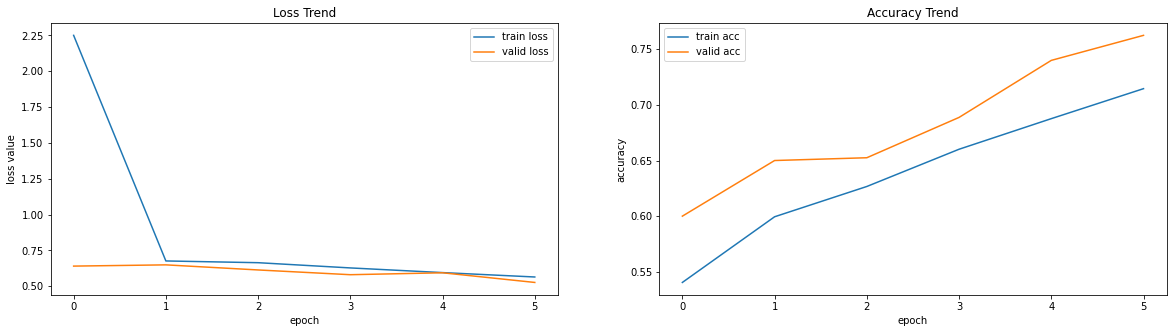

train start
step : 1/450, loss : 0.43568316102027893, acc : 0.8125
step : 21/450, loss : 0.4874172934464046, acc : 0.7827380952380952
step : 41/450, loss : 0.47832931832569403, acc : 0.7804878048780488
step : 61/450, loss : 0.5275157162400542, acc : 0.7489754098360656
step : 81/450, loss : 0.5313892474880925, acc : 0.7407407407407407
step : 101/450, loss : 0.5429509851602045, acc : 0.7289603960396039
step : 121/450, loss : 0.5419317695720136, acc : 0.7329545454545454
step : 141/450, loss : 0.5379143065594613, acc : 0.7402482269503546
step : 161/450, loss : 0.5393961320012253, acc : 0.7375776397515528
step : 181/450, loss : 0.5461647293185661, acc : 0.7337707182320442
step : 201/450, loss : 0.5457530107664231, acc : 0.7316542288557214
step : 221/450, loss : 0.5481354654914113, acc : 0.728789592760181
step : 241/450, loss : 0.5537396201948902, acc : 0.7256224066390041
step : 261/450, loss : 0.5483370692793894, acc : 0.7306034482758621
step : 281/450, loss : 0.5496424672018166, acc : 0.72

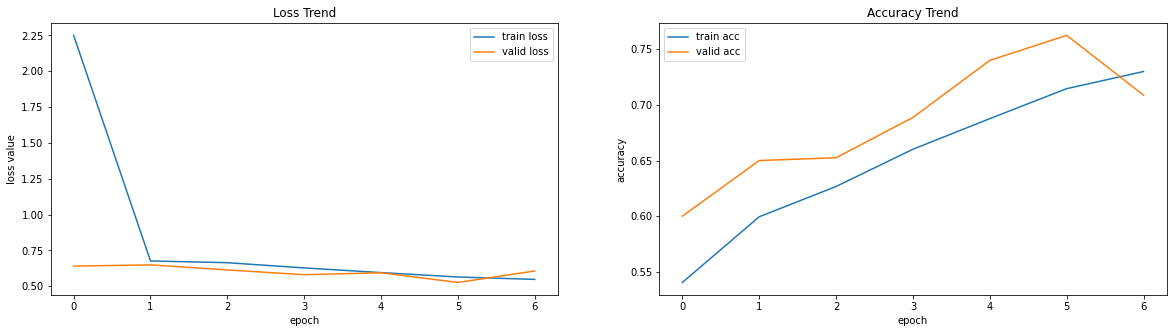

train start
step : 1/450, loss : 1.1117522716522217, acc : 0.5
step : 21/450, loss : 0.5585059310708728, acc : 0.7351190476190477
step : 41/450, loss : 0.5632907399317113, acc : 0.7210365853658537
step : 61/450, loss : 0.5547093934700137, acc : 0.7264344262295082
step : 81/450, loss : 0.5607690292376059, acc : 0.720679012345679
step : 101/450, loss : 0.5714206397533417, acc : 0.7122524752475248
step : 121/450, loss : 0.5591953322907125, acc : 0.7236570247933884
step : 141/450, loss : 0.5665264734139679, acc : 0.7154255319148937
step : 161/450, loss : 0.5641246515771617, acc : 0.7162267080745341
step : 181/450, loss : 0.5665667299078314, acc : 0.7168508287292817
step : 201/450, loss : 0.5653074515696189, acc : 0.7192164179104478
step : 221/450, loss : 0.5599570978281185, acc : 0.7217194570135747
step : 241/450, loss : 0.5612463792824647, acc : 0.720954356846473
step : 261/450, loss : 0.5616700307847896, acc : 0.7222222222222222
step : 281/450, loss : 0.5599903382652595, acc : 0.72575622

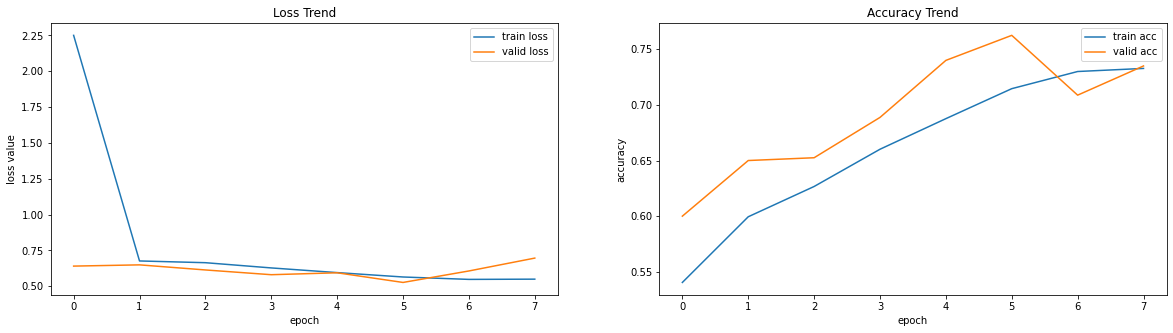

train start
step : 1/450, loss : 0.6139562129974365, acc : 0.6875
step : 21/450, loss : 0.5618794517857688, acc : 0.7261904761904762
step : 41/450, loss : 0.5599100364417564, acc : 0.7362804878048781
step : 61/450, loss : 0.5562615306651006, acc : 0.7397540983606558
step : 81/450, loss : 0.5489239313720186, acc : 0.7422839506172839
step : 101/450, loss : 0.5537008289063331, acc : 0.7376237623762376
step : 121/450, loss : 0.5506878115914084, acc : 0.7412190082644629
step : 141/450, loss : 0.5468157267739587, acc : 0.7433510638297872
step : 161/450, loss : 0.5472731023841764, acc : 0.7414596273291926
step : 181/450, loss : 0.5452167076465174, acc : 0.7420580110497238
step : 201/450, loss : 0.5436129819842713, acc : 0.7419154228855721
step : 221/450, loss : 0.5388521831904062, acc : 0.7446266968325792
step : 241/450, loss : 0.5411694507999539, acc : 0.7409232365145229
step : 261/450, loss : 0.5396069995630747, acc : 0.7420977011494253
step : 281/450, loss : 0.5376150771922488, acc : 0.743

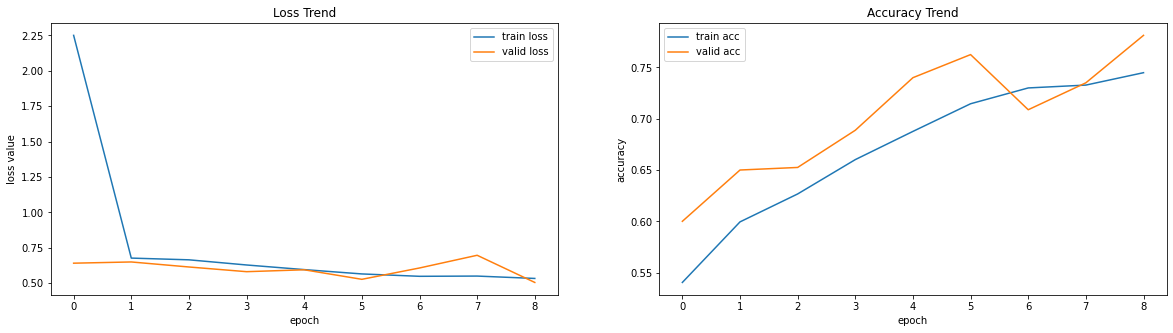

train start
step : 1/450, loss : 0.3062804341316223, acc : 0.875
step : 21/450, loss : 0.48980621425878434, acc : 0.75
step : 41/450, loss : 0.5006037997763332, acc : 0.7591463414634146
step : 61/450, loss : 0.5092817303098616, acc : 0.7530737704918032
step : 81/450, loss : 0.5167046915969731, acc : 0.753858024691358
step : 101/450, loss : 0.5134689635274434, acc : 0.7611386138613861
step : 121/450, loss : 0.5219819431216264, acc : 0.7582644628099173
step : 141/450, loss : 0.5175090403632915, acc : 0.7570921985815603
step : 161/450, loss : 0.5187403717951745, acc : 0.7550465838509317
step : 181/450, loss : 0.5221555826578351, acc : 0.7524171270718232
step : 201/450, loss : 0.5275374887446266, acc : 0.7512437810945274
step : 221/450, loss : 0.5251575367887635, acc : 0.7516968325791855
step : 241/450, loss : 0.5247244555425842, acc : 0.7497406639004149
step : 261/450, loss : 0.5293914632322231, acc : 0.7447318007662835
step : 281/450, loss : 0.531678994885543, acc : 0.7426601423487544
st

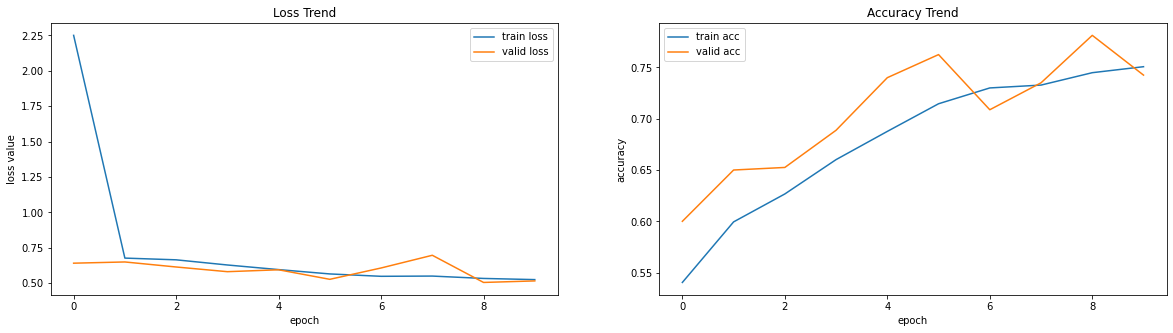

In [ ]:
epochs = 10
lr = 0.001

trainer = Trainer(lr=lr, epochs=epochs, save_root='/content', optimizer='adam', device='cuda').to('cuda')
trainer.train(train_loader, valid_loader)

In [ ]:
trainer.test(test_loader, '/content/model.pth')

test start


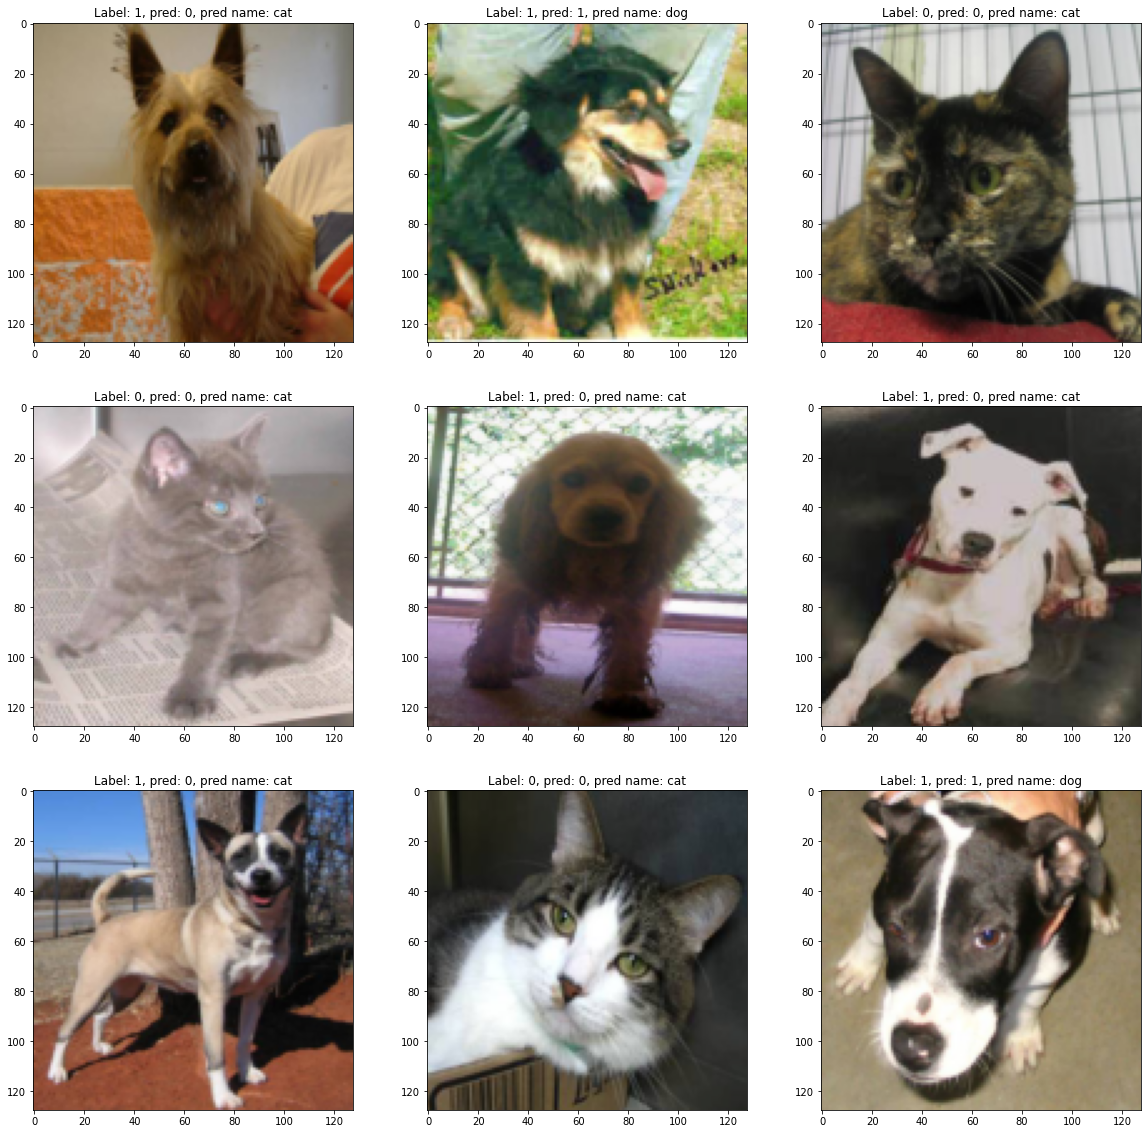

In [ ]:
trainer.test_visualize(Cats_Dogs_test, '/content/model.pth')